### Top 10 Algorithms for Binary Classification 

1. Naive Bayes
2. Logistic Regression
3. K-Nearest Neighbours
4. Support Vector Machine
5. Decision Tree 
6. Bagging  Decision Tree (Ensemble Learning I)
7. Boosted Decision Tree (Ensemble Learning II)
8. Random Forest (Ensemble Learning III)
9. Voting Classification (Ensemble Learning IV)
10. Deep Learning with a neuronal network

https://github.com/alexortner/teaching/blob/master/binary_classification/Top_10_Binary_Classification_BreastCancer.ipynb

In [1]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [2]:
# Estandarizador (transforma las variables en z-scores)
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error, ConfusionMatrixDisplay # Accuracy metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from scikitplot.metrics import plot_roc


In [3]:
import utils as ut
import pickle
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [4]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [5]:
df = load_data_prep()

In [6]:
#df1 = df[[ 'ccbd_diameter', 'sl2l_mean_length',
# 'sl2l_diameter', 'ccbd_mean_length',
# 'sl2l_volume', 'tral_volume','label']]
df1 = df[['sl2l_diameter', 'ccbd_diameter', 'ifol_diameter', 'ecpl_volume', 'tral_volume', 
       'sl2l_mean_length', 'ccbd_mean_length', 'label']]
df1.shape

(96, 8)

In [7]:
A = ['sl2l_diameter', 'ccbd_diameter', 'ifol_diameter', 'ecpl_volume', 'tral_volume', 
       'sl2l_mean_length', 'ccbd_mean_length']

In [8]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [9]:
X_= X_train.reset_index()
y_= y_train.reset_index()
X_=X_.drop('index', axis=1)
y_=y_.drop('index', axis=1)

In [10]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente
minmx_scale = MinMaxScaler()

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression # sci-kit learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold


In [12]:
pipelines = {
    'mnb':make_pipeline(MinMaxScaler(), MultinomialNB()),
    'lr':make_pipeline(StandardScaler(), LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),
    'knn':make_pipeline(StandardScaler(), KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)),
    'svm':make_pipeline(StandardScaler(), LinearSVC(C=0.0001)),
    'clf':make_pipeline(StandardScaler(), DecisionTreeClassifier(min_samples_split=10,max_depth=3)),
    'bglr':make_pipeline(StandardScaler(), BaggingClassifier(LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'bg':make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=3),max_samples=0.5,max_features=1.0,n_estimators=10)),
    'adb':make_pipeline(StandardScaler(), AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=0.5)),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, bootstrap = True, random_state=42, max_depth=3)),
    'evc':make_pipeline(MinMaxScaler(), VotingClassifier(estimators=[('mnb',MultinomialNB()),('lr', LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)),('rf',RandomForestClassifier(n_estimators=300,max_depth=3)),('svm',LinearSVC(C=0.0001))]))}


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_, y_) # arma los folds a partir de los datos

# acc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# pr_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# rc_sc_values = [] # aca es donde van a ir a parar los accuracys de cada fold
# scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
# indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
fit_models = {}

for algo, pipeline in pipelines.items():
      acc_values = []
      pr_sc_values = [] 
      rc_sc_values = []
      for train_index, test_index in skf.split(X_, y_): # va generando los indices que corresponden a train y test en cada fold
            X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
            y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]     # idem con los targets
            
            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_train_) # encuentro los parametros para el escaleo
            #X_train_ = scaler.transform(X_train_) # aplico la transformacion

            #scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
            #scaler.fit(X_test_) # encuentro los parametros para el escaleo
            #X_test_ = scaler.transform(X_test_) # aplico la transformacion
            
            model = pipeline.fit(X_train_, np.ravel(y_train_))
            probas_test = model.predict(X_test_)  # probabilidades con datos de evaluación
            
            acc_test = accuracy_score(y_test_, probas_test)
            pr_sc = precision_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            rc_sc = recall_score(y_test_.values, probas_test, average="weighted", pos_label=1)
            
            acc_values.append(acc_test)
            pr_sc_values.append(pr_sc)
            rc_sc_values.append(rc_sc)
            
            print(algo,'ac-sc: {}'.format(round(accuracy_score(y_test_, probas_test),3)),
                  'pr-sc: {}'.format(round(precision_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)),
                  'rc-sc: {}'.format(round(recall_score(y_test_.values, probas_test, average="weighted", pos_label="arriba"),3)))
      fit_models[algo] = model
            
      print('----------------------------------------------------')
      print('--------------PROMEDIOS--DE--',algo,'-------------------------')
      print('Accuracy {}'.format(round(np.mean(acc_values),3)), 
      'precision_score {}'.format(round(np.mean(pr_sc_values),3)),
      'recall_score {}'.format(round(np.mean(rc_sc_values),3)))
      print('----------------------------------------------------')
      print('----------------------------------------------------')

      fit_models[algo] = model

mnb ac-sc: 0.625 pr-sc: 0.633 rc-sc: 0.625
mnb ac-sc: 0.533 pr-sc: 0.553 rc-sc: 0.533
mnb ac-sc: 0.8 pr-sc: 0.855 rc-sc: 0.8
mnb ac-sc: 0.667 pr-sc: 0.673 rc-sc: 0.667
mnb ac-sc: 0.867 pr-sc: 0.896 rc-sc: 0.867
----------------------------------------------------
--------------PROMEDIOS--DE-- mnb -------------------------
Accuracy 0.698 precision_score 0.722 recall_score 0.698
----------------------------------------------------
----------------------------------------------------
lr ac-sc: 0.812 pr-sc: 0.817 rc-sc: 0.812
lr ac-sc: 0.733 pr-sc: 0.733 rc-sc: 0.733
lr ac-sc: 0.667 pr-sc: 0.707 rc-sc: 0.667
lr ac-sc: 0.6 pr-sc: 0.615 rc-sc: 0.6
lr ac-sc: 0.733 pr-sc: 0.733 rc-sc: 0.733
----------------------------------------------------
--------------PROMEDIOS--DE-- lr -------------------------
Accuracy 0.709 precision_score 0.721 recall_score 0.709
----------------------------------------------------
----------------------------------------------------
knn ac-sc: 0.375 pr-sc: 0.333 rc-s

https://stackoverflow.com/questions/72624190/how-to-use-sklearns-standard-scaler-with-make-pipeline

### 2. Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression # sci-kit learn

In [15]:
# lr = LogisticRegression(fit_intercept=True, penalty='l2', tol=1e-5, C=0.8, class_weight='balanced', solver='newton-cg', max_iter=5000, warm_start=True)
# lr.fit(X_scaled, y_train)

print("train shape: " + str(X_train.shape))
print("score on test: " + str(fit_models['lr'].score(X_test, y_test)))
print("score on train: "+ str(fit_models['lr'].score(X_, y_train)))

train shape: (76, 7)
score on test: 0.8
score on train: 0.75


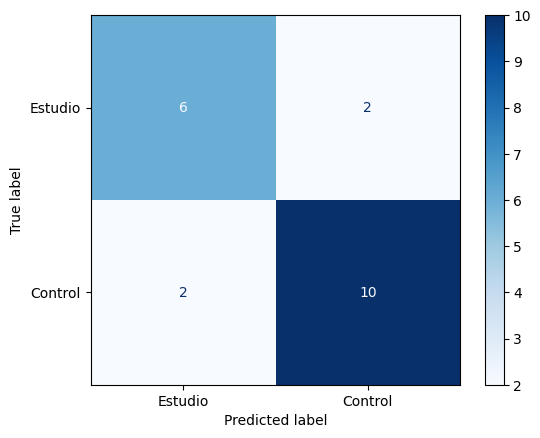

In [16]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(fit_models['lr'], X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [17]:
print(classification_report(y_true=y_test,y_pred=fit_models['lr'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.83      0.83      0.83        12

    accuracy                           0.80        20
   macro avg       0.79      0.79      0.79        20
weighted avg       0.80      0.80      0.80        20



In [18]:
y_predicted = fit_models['lr'].predict_proba(X_test)
lr = fit_models['lr'][-1]
print(lr.coef_[0][0], lr.intercept_[0])

-0.011915241990418617 -0.08996191803848318


In [19]:
import math
std = StandardScaler()
std.fit(df1)
data = std.transform(df1)

In [20]:
std_df = pd.DataFrame(data, index=df1.index, columns=df1.columns)
dat = lr.intercept_[0]+lr.intercept_[0]+lr.coef_[0][0]*std_df.sl2l_diameter.astype(float)+ \
                         lr.coef_[0][1]*std_df.ccbd_diameter.astype(float)+\
                         lr.coef_[0][2]*std_df.ifol_diameter.astype(float)+\
                         lr.coef_[0][3]*std_df.ecpl_volume.astype(float)+\
                         lr.coef_[0][4]*std_df.tral_volume.astype(float)+\
                         lr.coef_[0][5]*std_df.sl2l_mean_length.astype(float)+\
                         lr.coef_[0][6]*std_df.ccbd_mean_length.astype(float)

In [21]:
dt = dat.to_frame()
pscore = []

for index, row in dt.iterrows():
    pscore = np.append(pscore,math.exp(row[0])/(1+math.exp(row[0])))

df1['pscore'] = pd.DataFrame(pscore)


In [22]:
psbin = []
num0 = 0
num1 = 1
for index, row in df1.iterrows():
      if row[8] > 0.49:
          psbin = np.append(psbin,num1)
      else:
          psbin = np.append(psbin,num0)
df1['psbin'] = pd.DataFrame(psbin).astype(np.int64)
#df1['psbin'] = df['psbin'].astype(np.int64)


In [23]:
df1

,sl2l_diameter,ccbd_diameter,ifol_diameter,ecpl_volume,tral_volume,sl2l_mean_length,ccbd_mean_length,label,pscore,psbin
0,25.07,27.36,14.21,4295.10,19479.70,77.97,111.24,1,0.78,1
1,21.35,25.31,14.68,6884.02,14019.30,71.58,115.11,1,0.48,0
2,15.17,26.07,7.89,6884.02,17719.00,60.09,109.94,1,0.74,1
3,21.80,30.96,15.94,8952.53,15856.40,74.39,110.00,1,0.88,1
4,25.37,24.65,8.31,6884.02,22291.20,76.13,131.73,1,0.33,0
...,...,...,...,...,...,...,...,...,...,...
91,25.60,31.12,14.71,6136.14,15791.80,68.88,121.84,0,0.55,1
92,23.55,28.11,15.56,9530.31,7114.43,75.91,121.55,0,0.33,0
93,22.79,29.82,13.37,2097.61,18160.70,69.88,123.91,0,0.41,0
94,23.58,31.13,17.81,543.50,19594.30,72.83,126.01,0,0.38,0


<function matplotlib.pyplot.show(close=None, block=None)>

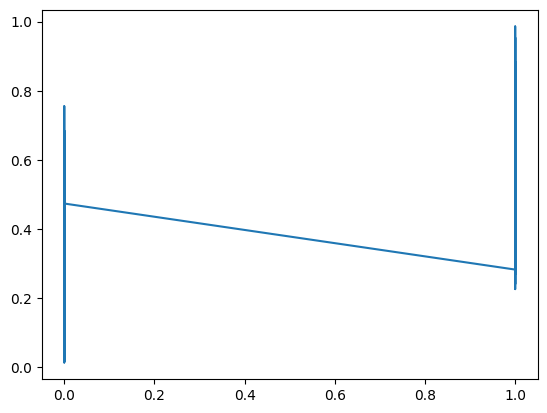

In [24]:
X = df1.label
y = df1.pscore
plt.plot(X, y)
plt.show

In [25]:
df1[['label','pscore']].describe()

,label,pscore
count,96.00,96.00
mean,0.52,0.48
std,0.50,0.26
min,0.00,0.01
25%,0.00,0.30
50%,1.00,0.46
75%,1.00,0.72
max,1.00,0.99


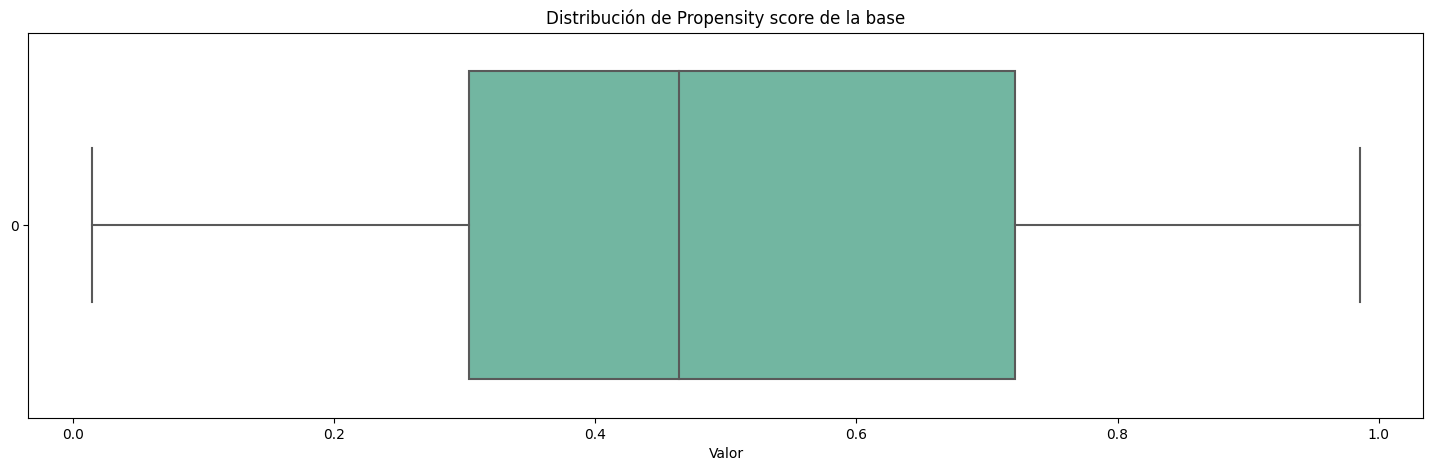

In [26]:
data_boxplot = sns.boxplot(data = pscore, orient = "h", palette = "Set2", whis = 3)
plt.title("Distribución de Propensity score de la base")
plt.xlabel("Valor")
data_boxplot.figure.set_size_inches(18,5)

In [27]:
data = df[['sl2l_diameter', 'ccbd_diameter', 'ifol_diameter', 'ecpl_volume', 'tral_volume', 
       'sl2l_mean_length', 'ccbd_mean_length']]
data.describe().astype(int)

,sl2l_diameter,ccbd_diameter,ifol_diameter,ecpl_volume,tral_volume,sl2l_mean_length,ccbd_mean_length
count,96,96,96,96,96,96,96
mean,23,27,14,6884,14393,76,120
std,2,3,2,3135,5262,6,9
min,15,7,3,315,318,60,70
25%,21,25,13,5450,11815,71,115
50%,22,28,15,6884,14885,75,122
75%,24,30,16,8867,17724,80,126
max,29,32,19,14015,26423,95,137


In [28]:
std_scale.fit(data)
scaled_data = pd.DataFrame(std_scale.transform(data),
                           columns=data.columns)

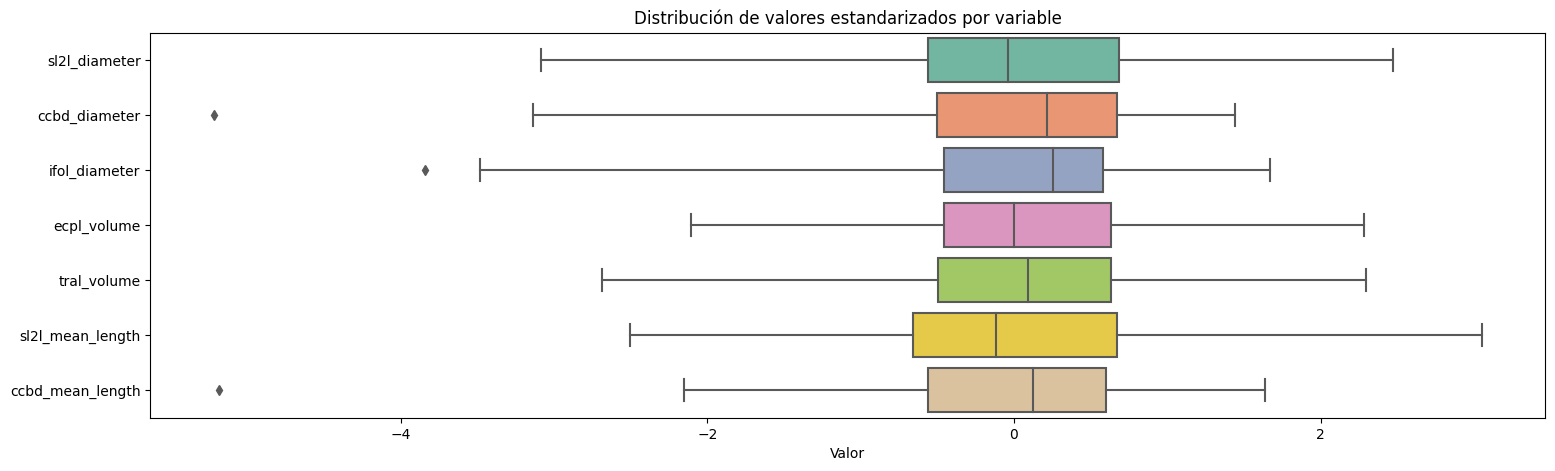

In [29]:
data_boxplot = sns.boxplot(data = scaled_data, orient = "h", palette = "Set2", whis = 3)
plt.title("Distribución de valores estandarizados por variable")
plt.xlabel("Valor")
data_boxplot.figure.set_size_inches(18,5)

Obtener Reg Log para 1 de 7

In [30]:
df2 = df[['sl2l_diameter', 'ccbd_diameter', 'ifol_diameter', 'ecpl_volume', 'tral_volume', 
       'sl2l_mean_length', 'ccbd_mean_length']]
df2.shape


(96, 7)

*** PRUEBAS

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [36]:
y = df2.loc[:, df2.columns == 'sl2l_diameter']
X = sm.add_constant(df2.loc[:, df2.columns != 'sl2l_diameter'])

print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          sl2l_diameter   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     4.731
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           0.000317
Time:                        07:40:35   Log-Likelihood:                -213.58
No. Observations:                  96   AIC:                             441.2
Df Residuals:                      89   BIC:                             459.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.5794      4.549  

In [54]:
y = df2.loc[:, df2.columns == 'sl2l_diameter']
X1 = sm.add_constant(df2.loc[:, df2.columns != 'sl2l_diameter'])
std = StandardScaler()
std1 = StandardScaler()
std.fit(X1)
std1.fit(y)
data = std.transform(X1)
y1 = std1.transform(y)
print(sm.OLS(y1, data).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.242
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                              4.785
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                    0.000281
Time:                        07:49:57   Log-Likelihood:                         -122.93
No. Observations:                  96   AIC:                                      257.9
Df Residuals:                      90   BIC:                                      273.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [55]:
y = df2.loc[:, df2.columns == 'ecpl_volume']
X1 = sm.add_constant(df2.loc[:, df2.columns != 'ecpl_volume'])
std = StandardScaler()
std1 = StandardScaler()
std.fit(X1)
std1.fit(y)
data = std.transform(X1)
y1 = std1.transform(y)
print(sm.OLS(y1, data).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.126
Model:                            OLS   Adj. R-squared (uncentered):              0.068
Method:                 Least Squares   F-statistic:                              2.164
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                      0.0538
Time:                        07:51:29   Log-Likelihood:                         -129.75
No. Observations:                  96   AIC:                                      271.5
Df Residuals:                      90   BIC:                                      286.9
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [56]:
y = df2.loc[:, df2.columns == 'ccbd_diameter']
X1 = sm.add_constant(df2.loc[:, df2.columns != 'ccbd_diameter'])
std = StandardScaler()
std1 = StandardScaler()
std.fit(X1)
std1.fit(y)
data = std.transform(X1)
y1 = std1.transform(y)
print(sm.OLS(y1, data).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.351
Model:                            OLS   Adj. R-squared (uncentered):              0.307
Method:                 Least Squares   F-statistic:                              8.099
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                    5.25e-07
Time:                        07:52:11   Log-Likelihood:                         -115.49
No. Observations:                  96   AIC:                                      243.0
Df Residuals:                      90   BIC:                                      258.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [57]:
y = df2.loc[:, df2.columns == 'ifol_diameter']
X1 = sm.add_constant(df2.loc[:, df2.columns != 'ifol_diameter'])
std = StandardScaler()
std1 = StandardScaler()
std.fit(X1)
std1.fit(y)
data = std.transform(X1)
y1 = std1.transform(y)
print(sm.OLS(y1, data).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.132
Model:                            OLS   Adj. R-squared (uncentered):              0.074
Method:                 Least Squares   F-statistic:                              2.286
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                      0.0423
Time:                        07:52:51   Log-Likelihood:                         -129.41
No. Observations:                  96   AIC:                                      270.8
Df Residuals:                      90   BIC:                                      286.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [58]:
y = df2.loc[:, df2.columns == 'sl2l_mean_length']
X1 = sm.add_constant(df2.loc[:, df2.columns != 'sl2l_mean_length'])
std = StandardScaler()
std1 = StandardScaler()
std.fit(X1)
std1.fit(y)
data = std.transform(X1)
y1 = std1.transform(y)
print(sm.OLS(y1, data).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.161
Model:                            OLS   Adj. R-squared (uncentered):              0.105
Method:                 Least Squares   F-statistic:                              2.885
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                      0.0128
Time:                        07:53:34   Log-Likelihood:                         -127.77
No. Observations:                  96   AIC:                                      267.5
Df Residuals:                      90   BIC:                                      282.9
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------